In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import h5py
from copy import deepcopy
params = {'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large'}
plt.rcParams.update(params)

In [2]:
offset=1
def get_opt(alpha,dphi,seed):
    dir=f"alpha{alpha:.0e}/dphi{dphi}/seed{seed}"
    opt_sd=np.loadtxt(f"{dir}/opt_sd.csv")
    with h5py.File(f'{dir}/coord.h5', 'r') as f:
        ##number of beads per polymer
        N=int(f['parameter/reference_Nbeads'][()]) 
        #kappa
        kappa=30/N
        ##number of polymers
        n_polym=int(f['parameter/n_polymers'][()]) 
        ##box dimensions 
        lxyz=np.array(f['parameter/lxyz'])
        ##box discretization
        nxyz=np.array(f['parameter/nxyz'])
        #discretization
        dxyz=lxyz/nxyz
        #adjust lengths and discretizations
        lxyz=lxyz-2*offset*dxyz
        nxyz=nxyz-2*offset
        #box volume
        V=np.prod(lxyz)
        #umbrella field
        umb_field=np.array(f["umbrella_field"])
        #rho0
        rho0=n_polym*N/V
        #cell volume
        V_cell=np.prod(dxyz)
        #natural density fluctuation
        var_phi=1/(rho0*kappa*V_cell) 
        #number of target cells
        n_cells_target=len(umb_field[umb_field>-1])
    T=np.loadtxt(f"{dir}/T.csv")
    opt=np.loadtxt(f"{dir}/opt.csv")/(n_cells_target*var_phi)
    opt_sd=opt_sd/(n_cells_target*var_phi)
    acc_rate=np.loadtxt(f"{dir}/acc_rate.csv")
    return T, opt, opt_sd, acc_rate
    


optimum:0.5560606503473424
optimum:0.5550021181397161
optimum:0.5549471621526575
optimum:0.5549280278847819
optimum:0.5546395003300294
optimum:0.5546395003300294


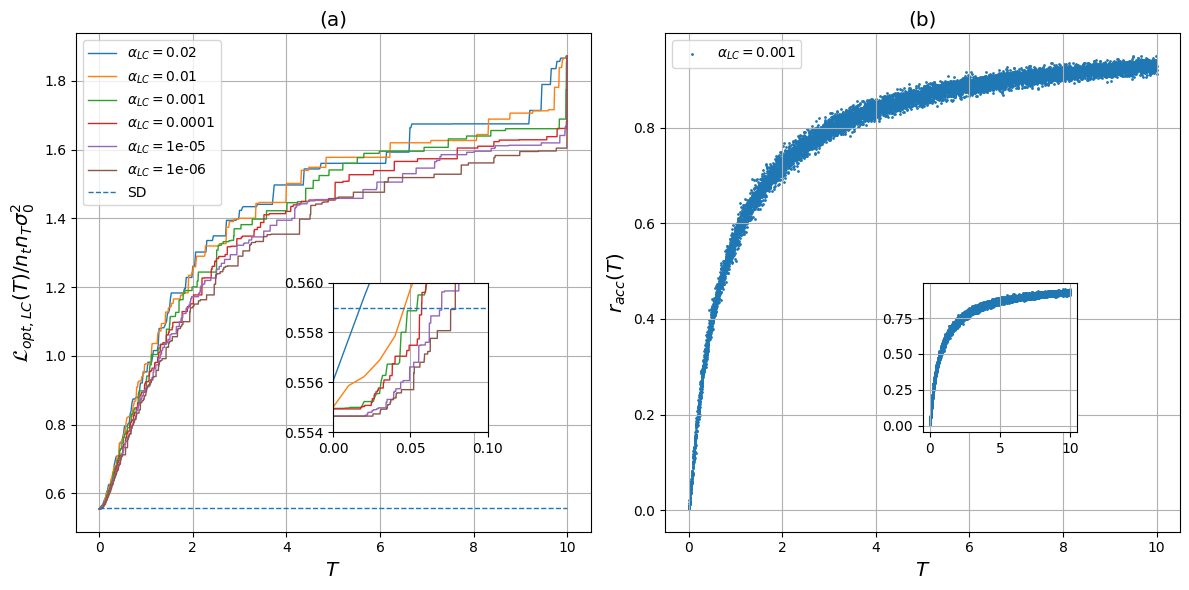

In [3]:
dphi=0.5
seed=0
ymins=np.array([0.554,0.965])
ymaxs=np.array([0.56,0.98])


fig,axs=plt.subplots(1,2,figsize=(12,6),dpi=100)
axs=axs.flatten()
alphas=np.array([2e-2,1e-2,1e-3,1e-4,1e-5,1e-6])

axs[0].set_ylabel(r"$\mathcal{L}_{opt,LC}(T)/n_tn_T\sigma_0^2$")
inset_ax0 = axs[0].inset_axes([0.5, 0.2, 0.3, 0.3]) 
#inset_ax0.set_ylabel("$L_{opt,LC}(T)/n_tn_T\sigma_0^2$")
# axs[1,0].set_ylabel("$L_{opt}$")
# axs[1,1].set_ylabel("$L_{opt}$")
axs[1].set_ylabel("$r_{acc}(T)$")
inset_ax1 = axs[1].inset_axes([0.5, 0.2, 0.3, 0.3]) 
#inset_ax1.set_ylabel("$r_{acc}(T)$")
inset_ax0.grid()
inset_ax1.grid()

for alpha in alphas:
    T, opt, opt_sd, acc_rate = get_opt(alpha,dphi, seed)
    opt[-2]=opt[-1]
    opt=opt[:-1]
    print(f"optimum:{np.min(opt)}")
    axs[0].plot(T,opt,lw=1,label=r"$\alpha_{LC}=$"+f"{alpha}")
    #axs[0].hlines(opt_sd,np.min(T),np.max(T),color="r",lw=1,label="SD")
    #show only snippet
    idx=np.argmax(T<0.16)
    inset_ax0.plot(T[idx:],opt[idx:],lw=1,label=r"$\alpha_{LC}=$"+f"{alpha}")
    # axs[2].hlines(opt_sd,0,T[idx],color="r",lw=1,label="SD")
    # axs[3].scatter(T[idx:],acc_rate[idx:],s=1)
alpha=1e-3
T, opt, opt_sd, acc_rate = get_opt(alpha,dphi,seed)
#plot acceptance rate etc for one alpha only
idx=np.argmax(T<0.16)
inset_ax1.scatter(T,acc_rate,s=1)
axs[1].scatter(T,acc_rate,lw=1,label=r"$\alpha_{LC}=$"+f"{alpha}",s=1)
inset_ax0.hlines(opt_sd,0,T[0],linestyles="dashed",lw=1,label="SD")
axs[0].hlines(opt_sd,0,T[0],linestyles="dashed",lw=1,label="SD")
for ax in axs:
    ax.grid()
    ax.set_xlabel("$T$")
    ax.legend()
    #ax.set_xscale('log')
axs[0].set_title("(a)")
axs[1].set_title("(b)")
inset_ax0.set_xlim(0,0.1)
inset_ax0.set_ylim(ymins[seed],ymaxs[seed])

# inset_ax1.set_ylim(0,0.3)
plt.tight_layout()
plt.savefig(f"opt_T_lam1p25_dphi{dphi}_seed{seed}_lin_cool.pdf")



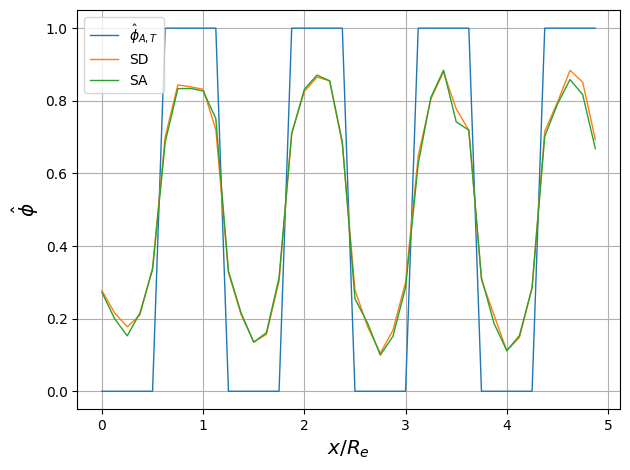

In [5]:
#analyse density field
seed=0
dphi=0.5
alpha=1e-3
dir=f"alpha{alpha:.0e}/dphi{dphi}/seed{seed}"
with h5py.File(f'{dir}/coord.h5', 'r') as f:
    ##number of beads per polymer
    N=int(f['parameter/reference_Nbeads'][()]) 
    #kappa
    kappa=30/N
    ##number of polymers
    n_polym=int(f['parameter/n_polymers'][()]) 
    n_poly_type=int(f['parameter/n_poly_type'][()]) 
    n_types=int(f['parameter/n_types'][()]) 
    ##box dimensions 
    lxyz=np.array(f['parameter/lxyz'])
    ##box discretization
    nxyz=np.array(f['parameter/nxyz'])
    #discretization
    dxyz=lxyz/nxyz
    #adjust lengths and discretizations
    lxyz[1]=lxyz[1]-2*offset*dxyz[1]
    nxyz[1]=nxyz[1]-2*offset
    #umbrella field
    umb_field=np.array(f["umbrella_field"])
    #area51
    area51=np.array(f["area51"])
    with h5py.File(f'{dir}/coord_ana.h5', 'r') as f:
        #get phi 
        phi=np.array(f['density_field'])

#only every other frame is optimized
# #number of accessible cells 
n_cells=int(len(area51[area51==0]))
# #field scaling type
scale=n_cells/(N*n_polym)
phi=phi*scale
phi=phi[:,:,area51==0].reshape(phi.shape[0],phi.shape[1],nxyz[0],nxyz[1],nxyz[2])
phi=phi[:,:,:,0]
#average phi over z
phi=phi.mean(axis=-1)
#get composition
comp_sd=phi[1,0]/(phi[1,0]+phi[1,1])
comp_sa=phi[3,0]/(phi[3,0]+phi[3,1])
umb_field=umb_field[umb_field>-1].reshape(2,nxyz[0],nxyz[2]).mean(axis=-1)
l_plot=np.arange(0,lxyz[0],dxyz[0])

plt.figure(dpi=100)
plt.grid()
plt.xlabel("$x/R_e$")
plt.ylabel(r"$\hat\phi$")
plt.plot(l_plot,umb_field[0],lw=1,label="$\hat\phi_{A,T}$")
plt.plot(l_plot,comp_sd,lw=1,label="SD")
plt.plot(l_plot,comp_sa,lw=1,label="SA")
#plt.plot(l_plot,phi[1,0]+phi[1,1],lw=1,label="$\hat\phi_A+\hat\phi_B$")
plt.legend()
plt.tight_layout()
plt.savefig(f"amplitude_lam0p25_dphi{dphi}_alpha{alpha}_seed{seed}.pdf")

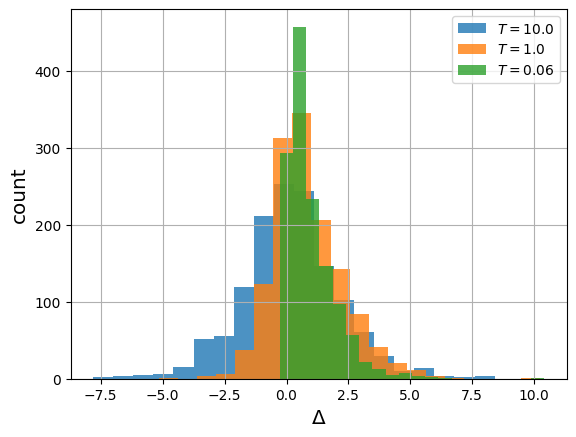

In [6]:
T_idxs=np.array([0,90000,99400])
# fig,axs=plt.subplots(2,2,figsize=(8,8),dpi=100)
# axs=axs.flatten()
# for i in range(len(T_idxs)):
#     axs[i].grid()
#     axs[i].set_xlabel("$\Delta$")
#     axs[i].set_ylabel("count")
#     axs[i].hist(delta_loss[T_idxs[i]],bins=20)
#     axs[i].set_title(f"$T=${T[T_idxs[i]]}")
# plt.tight_layout()

plt.figure(dpi=100)
plt.grid()
plt.xlabel("$\Delta$")
plt.ylabel("count")
for i in range(len(T_idxs)):
    plt.hist(delta_loss[T_idxs[i]],bins=20,alpha=0.8,label=f"$T=${T[T_idxs[i]]}")
plt.legend()
plt.savefig("delta_loss_hist_LC.pdf")
#title(f"$T=${T[T_idxs[i]]}")